# NLP - Sentiment Analysis (Large Movie Review) Project

# *I. Definition* #
## Project Overview ##

The project we will work on is the sentiment classification for a large movie review dataset from IMDB. Each movie review is a variable length of words and the sentiment of each movie review must be classified.

The dataset used in this project is from the link: http://ai.stanford.edu/~amaas/data/sentiment/. This is a publicly available dataset and is used in one of the Kaggle competition. The data (IMDB movie reviews) are written in 50,000 text files. Among these, 50% are positive reviews and 50% are negative reviews - 12,500 positive reviews, and 12,500 negative reviews in each of training and testing datasets.

This kind of task belong to the domain of Nature Language Processing (NLP). What makes this problem difficult is that the sequences can vary in length, be comprised of a very large vocabulary of input symbols and may require the model to learn the long-term context or dependencies between symbols in the input sequence. In this project, we will develop several LSTM recurrent neural network models for sequence classification problem specified, compare the performance of each model, and conclude the most suitable model for this particular problem.

<img src="images/007_movie.jpg" style="width:450;height:300px;">

## Problem Statement ##

The dataset is the Large Movie Review Dataset often referred to as the IMDB dataset.
The Large Movie Review Dataset contains 25,000 highly polar moving reviews (good or bad) for training and the same amount again for testing. The problem is to determine whether a given moving review has a positive or negative sentiment.

In this project, we will develop multiple potential solutions and pick the most suitable one for this problem. NLP problems can be solved by using simple "Bag of Words" method plus simple Machine Learning classifier like Naïve Bayes. However, the subtler way to solve the NLP problem would be using word embedding plus Deep Neural Networks such as LSTM (with optional CNN plus Maxpooling layer). This is because:

> -  Bag of Words method can only utilize the statistic information of the corpus (occurrence counts of words), while word embedding may capture the characteristics of each word in higher dimension vector space and better utilize word analogies; 

> -  LSTM can learn either the short-term or long-term context/dependencies between symbols in the input sequences while simple Machine Learning classifiers won’t able to do these. 
        
Based on the above reasons, our solution will be a model using word embedding plus RNN (using LSTM).

Text classification/sentiment analysis problem can be easily found in our daily life – Yelp review, movie review, survey for something, etc. The techniques suggested in this project can be easily applied to these applications.

In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['patch.force_edgecolor'] = True
%matplotlib inline
import seaborn as sns

# For data cleaning and data preprocessing
import re
from os import listdir
from string import punctuation
from nltk.corpus import stopwords
from collections import Counter

# For NLP using scikit-learn/"Bag of Words"
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer

# Keras - for data preprocessing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Keras - For creating model
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten, Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
#from keras.preprocessing import sequence

# For accessing IMDB dataset via built-in functions provided by Keras
from keras.datasets import imdb

Using TensorFlow backend.


# *II. Analysis* #
## Data Exploration ##

**Let's have some understanding about the directory and file structures for our datasets**

Note: the directory/file structures for the dataset (after untar and unzip) looks like below: aclImdb (root)/train(or test)/pos(or neg)/file(x_y). File is named in the format: file_id (x)– unique id for each review entry, number(y) (integer 1~4 means negative review, integer 7~10 means positive review). (Note: directory aclImdb has been renamed in my local environment – it's “datasets” directory now).

**Observations:** The sizes of the files vary in length. They could be 13,xxx bytes or larger, or could be 2xx bytes or smaller.
We don't see any empty files. Let's print out contents from some of those files.

In [2]:
def load_text(filename):
    f = open(filename, 'r', encoding='utf-8')
    content = f.read()
    f.close()
    return content

In [13]:
print("A sample of positive review: ==========")
print(load_text("datasets/train/pos/0_9.txt"))
print()
print("A sample of negative review: ==========")
print(load_text("datasets/train/neg/11090_1.txt"))

A sample of positive review: ==========
Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!

A sample of negative review: ==========
This movie looks like it was made for TV . For years I waited for some movie to be made about Rubin Carter, beca

**Observations:** the content of the review may contains punctuations, numbers, upper/lower case letters, short word (length equals 1), or stop words. Some symbols/words are candidates to be removed, reasons are as bellow:
1. Punctuactions: it's hard to tell the sentiments from them.
2. Numbers: some of the numbers don't carry the information about sentiment; it's difficult to intepret numbers to get sentiments from them.
3. Stop words ("a", "the", "this", "at", etc) usually don't carry information about sentiments.
4. Short words (like "a", "I", etc) don't carry information about sentiments.    

We will remove above symbols/words.

## Data Preprocessing and Data Visualization ##

In [3]:
def clean_text(line, return_line=True):
    # Remove the non-alphabet symbols which include punctuations, numbers, etc.
    review = re.sub('[^a-zA-Z]', ' ', line)
    # Convert the letters to lower case and split the tokens by space.
    tokens = review.lower().split()
    # Remove the stop words and short words.
    tokens = [word for word in tokens if (not word in set(stopwords.words('english'))) and (len(word)>1)]
    if return_line == False:
        return tokens
    else:
        return " ".join(tokens)

def update_vocab(tokens, vocab):
    # Update the count of the words in the vocab Counter data structure.
    vocab.update(tokens)
    return vocab

# Save the vocabulary into a file.
# Each line contains a word, space, then the word frequency.
# The first argument vocab_list should be a list of tuples - (word, word frequency) 
def save_vocab(vocab_list, vocab_file):
    with open(vocab_file, 'w', encoding='utf-8') as f:
        for (key, value) in vocab_list:
            content = key + ' ' + str(value) + '\n'
            f.write(content)

# Read the vocabulary from a file
# Return a list of tuples - (word, word freqency)
def load_vocab(vocab_file):
    with open(vocab_file, 'r', encoding='utf-8') as f:
        vocab_list = []
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            item = (curr_word, int(line[1]))
            vocab_list.append(item)
    return vocab_list

# Process the text files in the training directory: perform load file, clean text and update word counts.
# Save the cleaned texts to rows of a Datraframe - one row per file. 
def process_files_in_train_dir(directory, df, label, vocab):
    for filename in listdir(directory):
        path = directory + filename
        content = load_text(path)
        tokens = clean_text(content, False)
        vocab = update_vocab(tokens, vocab)
        cleaned_text = " ".join(tokens)
        df.loc[len(df)] = [cleaned_text, label]
    return df, vocab

# Process the text files in the testing directory: perform load file, and clean text.
# Save the cleaned texts to rows of a Datraframe - one row per file. 
def process_files_in_test_dir(directory, df, label):
    for filename in listdir(directory):
        path = directory + filename
        content = load_text(path)
        cleaned_text = clean_text(content, True)
        df.loc[len(df)] = [cleaned_text, label]
    return df

# Create a Counter for vocabulary updating.
# Create 2 Dataframes - one for training, one for testing dataset.
# Visit each directories from the root of the dataset and perform data cleaning.
# Save the cleaned text to the Dataframes.
def process_data(dataset_root, cleaned_train_data_file, cleaned_test_data_file):
    # Create a Counter data structure for our vocabulary.
    vocab = Counter()
    # Create 2 Dataframe for the cleaned texts - one for training data, one for testing data
    train_df = pd.DataFrame(columns=['text', 'ranking'])
    test_df = pd.DataFrame(columns=['text', 'ranking'])
    
    directory = dataset_root + '/train/pos/'
    print("Start processing files in directory: %s" %(directory))
    train_df, vocab = process_files_in_train_dir(directory, train_df, 1, vocab)
    directory = dataset_root + '/train/neg/'
    print("Start processing files in directory: %s" %(directory))
    train_df, vocab = process_files_in_train_dir(directory, train_df, 0, vocab)
        
    directory = dataset_root + '/test/pos/'
    print("Start processing files in directory: %s" %(directory))
    test_df = process_files_in_test_dir(directory, test_df, 1)
    directory = dataset_root + '/test/neg/'
    print("Start processing files in directory: %s" %(directory))
    test_df = process_files_in_test_dir(directory, test_df, 0)
        
    print(train_df)
    print(test_df)
    
    # Save the 2 Dataframes to separate files.
    train_df.to_csv(cleaned_train_data_file, encoding='utf-8', index=False)
    test_df.to_csv(cleaned_test_data_file, encoding='utf-8', index=False)
        
    print(len(vocab))
    # print the top words in the vocab
    print(vocab.most_common(500))
    return vocab

vocab = process_data('datasets', 'cleaned_train_data.csv', 'cleaned_test_data.csv')
save_vocab(vocab.most_common(), 'vocab.txt')

Start processing files in directory: datasets/train/pos/
Start processing files in directory: datasets/train/neg/
Start processing files in directory: datasets/test/pos/
Start processing files in directory: datasets/test/neg/
                                                    text ranking
0      bromwell high cartoon comedy ran time programs...       1
1      homelessness houselessness george carlin state...       1
2      brilliant acting lesley ann warren best dramat...       1
3      easily underrated film inn brooks cannon sure ...       1
4      typical mel brooks film much less slapstick mo...       1
5      comedic robin williams quirky insane robin wil...       1
6      yes art successfully make slow paced thriller ...       1
7      critically acclaimed psychological thriller ba...       1
8      night listener robin williams toni collette bo...       1
9      know robin williams god bless constantly shoot...       1
10     first read armistead maupins story taken human...   

73101
[('br', 101872), ('movie', 44047), ('film', 40162), ('one', 26795), ('like', 20281), ('good', 15147), ('time', 12727), ('even', 12656), ('would', 12436), ('story', 11990), ('really', 11739), ('see', 11479), ('well', 10668), ('much', 9766), ('get', 9312), ('bad', 9308), ('people', 9287), ('also', 9159), ('first', 9064), ('great', 9061), ('made', 8364), ('way', 8026), ('make', 8025), ('could', 7923), ('movies', 7668), ('think', 7298), ('characters', 7159), ('character', 7024), ('watch', 6974), ('two', 6906), ('films', 6889), ('seen', 6681), ('many', 6675), ('life', 6632), ('plot', 6589), ('acting', 6494), ('never', 6485), ('love', 6454), ('little', 6438), ('best', 6416), ('show', 6295), ('know', 6167), ('ever', 5998), ('man', 5982), ('better', 5740), ('end', 5651), ('still', 5624), ('say', 5396), ('scene', 5383), ('scenes', 5213), ('go', 5159), ('something', 5077), ('back', 4972), ('real', 4738), ('watching', 4606), ('though', 4566), ('thing', 4529), ('old', 4526), ('years', 4516),

In [2]:
train_df = pd.read_csv("cleaned_train_data.csv", encoding="utf-8")
test_df = pd.read_csv("cleaned_test_data.csv", encoding="utf-8")
print(train_df)
print()
print(test_df)

                                                    text  ranking
0      bromwell high cartoon comedy ran time programs...        1
1      homelessness houselessness george carlin state...        1
2      brilliant acting lesley ann warren best dramat...        1
3      easily underrated film inn brooks cannon sure ...        1
4      typical mel brooks film much less slapstick mo...        1
5      comedic robin williams quirky insane robin wil...        1
6      yes art successfully make slow paced thriller ...        1
7      critically acclaimed psychological thriller ba...        1
8      night listener robin williams toni collette bo...        1
9      know robin williams god bless constantly shoot...        1
10     first read armistead maupins story taken human...        1
11     liked film action scenes interesting tense wel...        1
12     many illnesses born mind man given life modern...        1
13     enjoyed night listener much one better movies ...        1
14     nig

In [3]:
np.random.seed(1)

# Random shuffle the rows in the Dataframe of the training dataset
new_train_df = train_df.reindex(np.random.permutation(len(train_df)))
print(new_train_df)

# Random shuffle the rows in the Dataframe of the testing dataset
new_test_df = test_df.reindex(np.random.permutation(len(test_df)))
print(new_test_df)

                                                    text  ranking
21492  copy vhs think television networks play every ...        0
9488   several extremely well ratings point superb ex...        1
16933  still know forced sit whole thing film worth m...        0
12604  mt little sister self proclaimed horror movie ...        0
8222   personally seen many disney movies lifetime th...        1
9110   day california presidential primary midnight s...        1
21196  unentertaining uninvolving hybrid cruel intent...        0
17193  watched immediately seeing hillside cannibals ...        0
23846  killings movie bad sure movie even worse even ...        0
10415  aside great movie metropolis oldest pure sci f...        1
9018   saw detroit must original run literally rolled...        1
24056  holy crap movie bad watched joke even bad good...        0
19992  br br cheap looking ugly film even seem entert...        0
11464  like films school bullies brave children hilar...        1
10641  mov

In [4]:
X_train = new_train_df['text']
y_train = new_train_df['ranking']
X_test = new_test_df['text']
y_test = new_test_df['ranking']
print("Training review size {}, training label size {}".format(X_train.shape, y_train.shape))
print("Testing review size {}, testing label size {}".format(X_test.shape, y_test.shape))

Training review size (25000,), training label size (25000,)
Testing review size (25000,), testing label size (25000,)


**Let's look at the review length -**
when creating the word embedding layer in Keras, we need to pass length of sequences as a parameter.

Text(0.5, 1.0, 'Review Length in Words for IMDB Training Dataset')

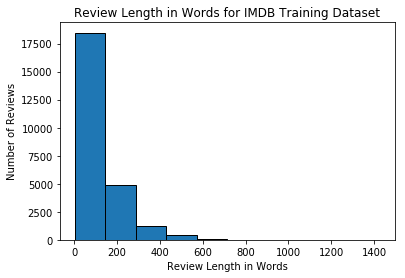

In [5]:
review_length_train = [len(x.split()) for x in X_train]
plt.hist(review_length_train)
plt.xlabel("Review Length in Words")
plt.ylabel("Number of Reviews")
plt.title("Review Length in Words for IMDB Training Dataset")

Text(0.5, 1.0, 'Review Length in Words for IMDB Training Dataset')

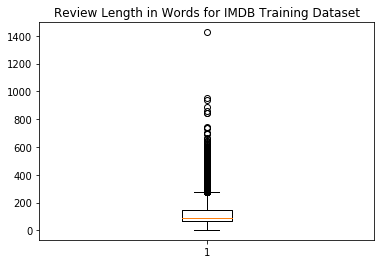

In [8]:
plt.boxplot(review_length_train)
plt.title("Review Length in Words for IMDB Training Dataset")

**Let's look at review length in boxplots to get an idea about the distribution of the data.**

Text(0.5, 1.0, 'Review Length in Words for IMDB Testing Dataset')

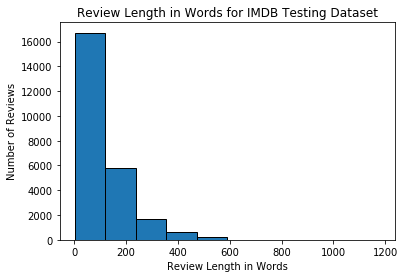

In [9]:
review_length_test = [len(x.split()) for x in X_test]
plt.hist(review_length_test)
plt.xlabel("Review Length in Words")
plt.ylabel("Number of Reviews")
plt.title("Review Length in Words for IMDB Testing Dataset")

Text(0.5, 1.0, 'Review Length in Words for IMDB Testing Dataset')

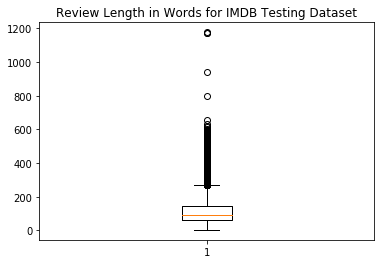

In [10]:
plt.boxplot(review_length_test)
plt.title("Review Length in Words for IMDB Testing Dataset")

In [11]:
print("Mean of the review length in training set is: %.2f" %np.mean(review_length_train))
print("Median of the review length in training set is: %.2f" %np.median(review_length_train))
print("Standard deviation of the review length in training set is: %.2f" %np.std(review_length_train))
print()
print("Mean of the review length in testing set is: %.2f" %np.mean(review_length_test))
print("Median of the review length in testing set is: %.2f" %np.median(review_length_test))
print("Standard deviation of the review length in testing set is: %.2f" %np.std(review_length_test))

Mean of the review length in training set is: 123.28
Median of the review length in training set is: 91.00
Standard deviation of the review length in training set is: 93.50

Mean of the review length in testing set is: 120.44
Median of the review length in testing set is: 89.00
Standard deviation of the review length in testing set is: 91.11


**Observations:** Looks like most reviews are less than 500 words. The average review length is around 120 words. Set input length to 500 when creating word embedding should be fine.

In [5]:
vocab_list = load_vocab('vocab.txt')

print(len(vocab_list))
print(vocab_list[0])
print(vocab_list[-1])

73101
('br', 101872)
('whelk', 1)


**Let's have some guess on the relationship between 'word frequency' and the learning of the models.**
If we have 120 words in each review and 12,500 reviews (positive or negative) in total, we have around 1,500,000 occurrences of words in the training set. If a word occurs 150 times, it then contributes to 0.0001 of the total occurrences of the words. If a word occurs less than 15 times, it then contribute only 1e-5 (0.00001) to the total occurrences of the words - how likely the model will learn much from it? Or, if a word occurs less than 12 times (~0.1 % of 12,500), means we saw that word only in every 1000 reviews, can the model learn much from it?

In [15]:
# Let's print out some numbers to find out more on the frequency of the words in our training dataset.
min_occurrences = [300, 150, 80, 30, 10, 5, 4, 3]

print("Some statistic numbers for words in the training set:")
for i in range(len(min_occurrences)):
    word_count = [count for (word, count) in vocab_list if count >= min_occurrences[i]]
    print("There are {} words with frequency count >= {}.".format(len(word_count), min_occurrences[i]))

Some statistic numbers for words in the training set:
There are 1612 words with frequency count >= 300.
There are 2943 words with frequency count >= 150.
There are 4936 words with frequency count >= 80.
There are 9998 words with frequency count >= 30.
There are 19706 words with frequency count >= 10.
There are 28600 words with frequency count >= 5.
There are 32124 words with frequency count >= 4.
There are 37233 words with frequency count >= 3.


Our guess is: if our model only learn from top 10,000 words or even top 5,000 words - will that be good enough? Let's do some experiment later to confirm this! Another obversation is: more than half of the words (73101/2 ~ 36,550) occur less than 4 times.

Text(0, 0.5, 'Number of Words')

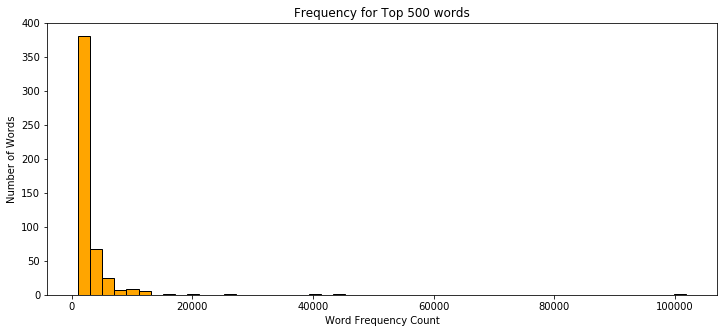

In [16]:
# Let's get the word frequency from vocab_list
freq = [count for (word, count) in vocab_list]

plt.figure(figsize=(12,5))
plt.hist(freq[:500], bins=50, color='orange')
plt.title("Frequency for Top 500 words")
plt.xlabel("Word Frequency Count")
plt.ylabel("Number of Words")

**Observations:** there are over 350 words with frequency count less than or equal to 2,000. There are only a few high frequency (count >=20,000) words.

Text(0, 0.5, 'Number of Words')

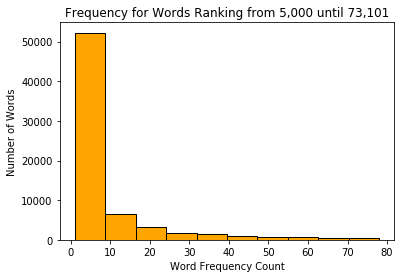

In [17]:
# Let's look at the frequency for words ranking from 5000 until 73,101 (the last word in our vocabulary)
plt.hist(freq[5000:], color='orange')
plt.title("Frequency for Words Ranking from 5,000 until 73,101")
plt.xlabel("Word Frequency Count")
plt.ylabel("Number of Words")

**Observations:** there are over 50,000 words with occurrence less than 10. The highest occurrence here is less than 80. If the word with that occurrence reflect a positive (or negative) sentiment, it only shows up 6 times in every 1,000 reviews. (80/12500 = 0.0064) - is that frequency high enough for model to learn? We will keep this information in mind.

## Algorithms and Techniques ##
The algorithms and techniques used in our benchmark model are: Naïve Bayes with Bag of Words.

The algorithms and techniques used in our advanced Deep Neural Network models are: word embedding, RNN, LSTM, and CNN. We will use two different approaches to construct the word embedding layer – there will be at least one model created for each approach. One approach uses trainable word embedding layer based on vocabulary/tokens generated from the training set (after text cleaning by us, and tokenizing by Keras tools) and the other approach uses pre-trained Glove (Global Vectors for Word Representation) glove.6B.50d (6B tokens, 400K vocab, uncased, 50-dimension vector) as word embedding layer. The models for potential solutions will include the following combinations of neural network layers – embedding layer, (optional convolutional layer and Maxpooling layer), LSTM layer(s), Dropout layer, and Dense layer. We will also create a reference models, which uses vocabulary generated/loaded by imdb.load_data API provided by Keras, to compare with our results. The training/testing data returned by imdb.load_load API are real-valued vectors that are ready to be used by Deep Neural Networks.

### The Bag of Words Representation ###
Text Analysis is a major application field for machine learning algorithms. However the raw data, a sequence of symbols cannot be fed directly to the algorithms themselves as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length.

To address this, scikit-learn provides utilities for the most common ways to extract numerical features from text content, namely:

> -  tokenizing strings and giving an integer id for each possible token, for instance by using white-spaces and punctuation as token separators.
> -  counting the occurrences of tokens in each document.
> -  normalizing and weighting with diminishing importance tokens that occur in the majority of samples / documents.
    
In this scheme, features and samples are defined as follows:

> -  each individual token occurrence frequency (normalized or not) is treated as a feature.
> -  the vector of all the token frequencies for a given document is considered a multivariate sample.

A corpus of documents can thus be represented by a matrix with one row per document and one column per token (e.g. word) occurring in the corpus.

We call vectorization the general process of turning a collection of text documents into numerical feature vectors. This specific strategy (tokenization, counting and normalization) is called the Bag of Words or “Bag of n-grams” representation. Documents are described by word occurrences while completely ignoring the relative position information of the words in the document.

Reference for above explanations: http://scikit-learn.org/stable/modules/feature_extraction.html

### Word Embedding ###
To use Deep Neural Network for text classification, we need to convert the words in reviews into real valued vectors – this is a popular technique when working with text. This is a technique where words are encoded as real-valued vectors in a high dimensional space, where the similarity between words in terms of meaning translates to closeness in the vector space.

In Keras, the embedding matrix is represented as a "layer", and maps positive integers (indices corresponding to words) into dense vectors of fixed size (the embedding vectors). It can be trained or initialized with a pretrained embedding.  

The `Embedding()` layer takes an integer matrix of size (batch size, max input length) as input. This corresponds to sentences converted into lists of indices (integers), as shown in the figure below.

<img src="images/embedding1.png" style="width:700px;height:250px;">
<caption><center> Figure 1: Embedding layer. This example shows the propagation of two examples through the embedding layer. Both have been post zero-padded to a length of `max_len=5`. The final dimension of the representation is  `(2,max_len,50)` because the word embeddings we are using are 50 dimensional. </center></caption>

The largest integer (i.e. word index) in the input should be no larger than the vocabulary size. The layer outputs an array of shape (batch size, max input length, dimension of word vectors).

Source of the picture: course "Sequence Models" by deeplearning.ai

### Using Pre-Trained GloVe Embedding ###
GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus. More descriptions about Glove can be found in the following 2 links:

1. https://nlp.stanford.edu/pubs/glove.pdf
2. https://nlp.stanford.edu/projects/glove/

Citing some descriptions from the first link: A few years ago, Mikolov et al. introduced an evaluation scheme based on word analogies that examining not the scalar distance between word vectors (which was the primary method to evaluate the intrinsic quality of word representations), but rather their various dimensions of difference. For example, the analogy “king is to queen as man is to woman” should be encoded in the vector space by the vector equation king − queen = man − woman. This evaluation scheme favors models that produce dimensions of meaning, thereby capturing the multi-clustering idea of distributed representations. The two main model families for learning word vectors are: 
1. global matrix factorization methods, such as latent semantic analysis (LSA) 
2. local context window methods, such as the skip-gram model.

Currently, both families suffer significant drawbacks. While methods like LSA efficiently leverage statistical information, they do relatively poorly on the word analogy task. Methods like skip-gram may do better on the analogy task, but they poorly utilize the statistics of the corpus since they train on separate local context windows instead of on global co-occurrence counts. Glove is a weighted least squares model that trains on global word-word co-occurrence counts and thus makes efficient use of statistics. Besides that, it is proved to have very good performance (high accuracy) on the word analogy dataset, which makes it an attrative choice of word embedding layer.

### Recurrent Neural Networks ###
The idea behind RNNs is to make use of sequential information. In a traditional neural network, we assume that all inputs (and outputs) are independent of each other. But for many tasks that’s a very bad idea. If you want to predict the next word in a sentence you better know which words came before it. RNNs are called recurrent because they perform the same task for every element of a sequence, with the output being depended on the previous computations. Another way to think about RNNs is that they have a “memory” which captures information about what has been calculated so far. Because of the nature that the output of current time step is depending on the output from previous time step, RNN is a good choice in predicting trend in sequence (time-series) data like stock marketing price, and many NLP tasks such as text classification (sentiment analysis), machine translation, speech recognition, etc. Our model will be based on RNN networks. 

<img src="images/LSTM3-SimpleRNN_colah.png" style="width:500;height:300px;">
<caption><center> Figure 1: The repeating module in a standard RNN </center></caption>

Source of the picture: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

Reference for RNN: http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/


### LSTM Networks ###

Long short-term memory (LSTM) units are units of a recurrent neural network (RNN). A common LSTM unit is composed of a cell, an input (or update) gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell. LSTM networks are well-suited to classifying and making predictions based on time-series data, since there can be lags of unknown duration between important events in a time series. LSTMs were developed to deal with the vanishing gradient problems that can be encountered when training traditional RNNs.

<img src="images/LSTM3-chain_colah.png" style="width:500;height:400px;">
<caption><center> Figure 2: The repeating module in an LSTM network </center></caption>

Source of the picture: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

Reference for LSTM network: https://en.wikipedia.org/wiki/Long_short-term_memory.

Reference for sequence classification with LSTM: https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/.

### Convolutional Neural Network and LSTM for Sequence Classification ###

Convolutional neural networks excel at learning the spatial structure in input data. The IMDB review data does have a one-dimensional spatial structure in the sequence of words in reviews and the CNN may be able to pick out invariant features for good and bad sentiment. This learned spatial features may then be learned as sequences by an LSTM layer. Another advantage of using CNN is: it will greatly reduce the training time – especially when we have a large vocabulary and large dataset. 

Reference for using CNN in sentiment analysis:
https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/


## Benchmark ##
The benchmark result we will use in this project is the result from a Naïve Bayes classifier with “Bag of Words” algorithm. We will use CountVectorizer class in scikit-learn to fit (build a vocabulary) and transform (vectorize) the training text. We then use MultinomialNB classifier (a Naive Bayes classifier for multinomial models) to fit the training set and predict on the testing set. Naïve Bayes plus “Bag of Words” is the simplest but almost the most common model for NLP tasks. This combination should be suitable for our benchmark model.

# *III. Methodology* #
## Implementation ##
### Benchmark Model ###

**Note:**
1. We will use CountVectorizer class in scikit-learn which implements both tokenization and occurrence counting. It's a common vectorizer which uses "Bag of Words" technology. 
2. We've tried several different numbers for max_features based on the word frequency observed eariler. The following are the test accuracy data:
> -  Max_features: 5,000           Test accuracy: 83.96
> -  Max_features: 10,000          Test accuracy: 83.62
> -  Max_features: 20,000          Test accuracy: 83.08
> -  Max_features: 30,000          Test accuracy: 82.65
> -  Max_features: 40,000          Test accuracy: 82.56

We will use top 5,000 words in our Deep Neural Network models as well.

In [6]:
# Transform each text into a vector of word counts
vectorizer = CountVectorizer(max_features=5000)

training_features = vectorizer.fit_transform(X_train) 
test_features = vectorizer.transform(X_test)

# Training
model = MultinomialNB()
model.fit(training_features, y_train)
y_pred = model.predict(test_features)

# Evaluation
acc = accuracy_score(y_test, y_pred)

print("Test accuracy on the IMDB dataset: {:.2f}".format(acc*100))

Test accuracy on the IMDB dataset: 83.96


### Trainable word embedding  plus RNN/LSTM ###

**Note:**
1. Let's set the vocabulary_size to 5000 according to the parameters applied on the benchmark model when it achieves the best test accuracy.
2. Let's set the maxLen (maximum input length) to 500 according to the visualization results.
3. The Glove word representation file we have uses 50-dimension word vector. Set embedding_vecor_length to 50 so we may compare the trainable word embedding with the pre-trained word embedding.

In [7]:
vocabulary_size = 5000
maxLen = 500
embedding_vector_length = 50

**Note:** Tokenizer is a class in Keras for vectorizing texts, or/and turning texts into sequences (=list of word indexes, where the word of rank i in the dataset (starting at 1) has index i) - the vocabulary generated by Tokenizor class is ordered by the word frequency.

In [8]:
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_train_data = pad_sequences(X_train_sequences, maxlen=maxLen)

X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_data = pad_sequences(X_test_sequences, maxlen=maxLen)

#### Model 1: Simple LSTM - the Initial Model for Recurrent Neural Networks ####

**Note:**
Use an LSTM with 100 hidden units. The common choices for hidden unit size are 100/128. We use 100 here.

In [59]:
model_token1 = Sequential()
model_token1.add(Embedding(vocabulary_size, embedding_vecor_length, input_length=maxLen))
model_token1.add(LSTM(100))
model_token1.add(Dense(1, activation='sigmoid'))
model_token1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_token1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 500, 50)           250000    
_________________________________________________________________
lstm_14 (LSTM)               (None, 100)               60400     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 101       
Total params: 310,501
Trainable params: 310,501
Non-trainable params: 0
_________________________________________________________________
None


In [60]:
model_token1.fit(X_train_data, np.array(y_train), epochs = 3, batch_size = 128)

Epoch 1/3
25000/25000 [==============================] - 501s 20ms/step - loss: 0.4891 - acc: 0.7652
Epoch 2/3
25000/25000 [==============================] - 529s 21ms/step - loss: 0.2606 - acc: 0.8988
Epoch 3/3
25000/25000 [==============================] - 496s 20ms/step - loss: 0.2154 - acc: 0.9206


In [61]:
loss, acc = model_token1.evaluate(X_test_data, np.array(y_test))
print()
print("Test accuracy = ", acc)

25000/25000 [==============================] - 129s 5ms/step

Test accuracy =  0.87188


#### Model 2: LSTM with Dropout ####

**Note:** Neural Network sometimes have the problem of overfitting. Dropout can be applied between layers using Dropout layer in Keras. Dropout rate 0.2~0.5 are common choices. We use dropout rate 0.2 and 0.3 for the first and second dropout layer respectively.

In [87]:
model_token2 = Sequential()
model_token2.add(Embedding(vocabulary_size, embedding_vecor_length, input_length=maxLen))
model_token2.add(Dropout(0.2))
model_token2.add(LSTM(100))
model_token2.add(Dropout(0.3))
model_token2.add(Dense(1, activation='sigmoid'))
model_token2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_token2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 500, 50)           250000    
_________________________________________________________________
dropout_19 (Dropout)         (None, 500, 50)           0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 100)               60400     
_________________________________________________________________
dropout_20 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 101       
Total params: 310,501
Trainable params: 310,501
Non-trainable params: 0
_________________________________________________________________
None


In [88]:
model_token2.fit(X_train_data, np.array(y_train), epochs = 3, batch_size = 128)

Epoch 1/3
25000/25000 [==============================] - 631s 25ms/step - loss: 0.5291 - acc: 0.7481
Epoch 2/3
25000/25000 [==============================] - 630s 25ms/step - loss: 0.2659 - acc: 0.8960
Epoch 3/3
25000/25000 [==============================] - 641s 26ms/step - loss: 0.2195 - acc: 0.9172


In [89]:
loss, acc = model_token2.evaluate(X_test_data, np.array(y_test))
print()
print("Test accuracy = ", acc)

25000/25000 [==============================] - 149s 6ms/step

Test accuracy =  0.87216


#### Model 3: CNN, LSTM with Dropout ####

**Note:**
As discussed in "Algorithms and Techniques" section, we may apply CNN plus LSTM on NLP tasks. We use Conv1D with the common parameter settings: filter_size=32, kernal_size=3 (2, 3, 5 are common choices for kernel size), padding = 'same', activation='relu'. We use a MaxPooling1D with pool_size=2 (which is also a common choice for pool_size). We then add a LSTM with 100 hidden units (common choices), and Dropout layer with dropout rate 0.3 (common choices) and finally a Dense layer.

In [65]:
model_token3 = Sequential()
model_token3.add(Embedding(vocabulary_size, embedding_vecor_length, input_length=maxLen))
model_token3.add(Conv1D(32, 3, padding='same', activation='relu'))
model_token3.add(MaxPooling1D(pool_size=2))
model_token3.add(LSTM(100))
model_token3.add(Dropout(0.3))
model_token3.add(Dense(1, activation='sigmoid'))
model_token3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_token3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 500, 50)           250000    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 500, 32)           4832      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 101       
Total params: 308,133
Trainable params: 308,133
Non-trainable params: 0
_________________________________________________________________


In [66]:
model_token3.fit(X_train_data, np.array(y_train), epochs = 3, batch_size = 128)

Epoch 1/3
25000/25000 [==============================] - 578s 23ms/step - loss: 0.4251 - acc: 0.7876
Epoch 2/3
25000/25000 [==============================] - 577s 23ms/step - loss: 0.2382 - acc: 0.9099
Epoch 3/3
25000/25000 [==============================] - 575s 23ms/step - loss: 0.1978 - acc: 0.9272


In [67]:
loss, acc = model_token3.evaluate(X_test_data, np.array(y_test))
print()
print("Test accuracy = ", acc)

25000/25000 [==============================] - 75s 3ms/step

Test accuracy =  0.86428


#### Model 4: Multiple LSTM Layers ####

We stack up 2 LSTM layers, each one has 100 hidden units and followed by a Dropout layer. **Note:** We need to set "return_sequences" to "True" for the first LSTM layer and "False" for the second LSTM layer. This is because we want the first LSTM layer return the full sequences and the second LSTM layer return the last output only.  

In [70]:
model_token4 = Sequential()
model_token4.add(Embedding(vocabulary_size, embedding_vecor_length, input_length=maxLen))
model_token4.add(LSTM(100, return_sequences=True))
model_token4.add(Dropout(0.2))
model_token4.add(LSTM(100, return_sequences=False))
model_token4.add(Dropout(0.2))
model_token4.add(Dense(1, activation='sigmoid'))
model_token4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_token4.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 500, 50)           250000    
_________________________________________________________________
lstm_19 (LSTM)               (None, 500, 100)          60400     
_________________________________________________________________
dropout_17 (Dropout)         (None, 500, 100)          0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_18 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 101       
Total params: 390,901
Trainable params: 390,901
Non-trainable params: 0
_________________________________________________________________
None

In [71]:
model_token4.fit(X_train_data, np.array(y_train), epochs = 3, batch_size = 128)

Epoch 1/3
25000/25000 [==============================] - 1470s 59ms/step - loss: 0.4007 - acc: 0.8117
Epoch 2/3
25000/25000 [==============================] - 1636s 65ms/step - loss: 0.2508 - acc: 0.9011
Epoch 3/3
25000/25000 [==============================] - 1541s 62ms/step - loss: 0.2171 - acc: 0.9175


In [72]:
loss, acc = model_token4.evaluate(X_test_data, np.array(y_test))
print()
print("Test accuracy = ", acc)

25000/25000 [==============================] - 251s 10ms/step

Test accuracy =  0.86604


**Observation:** It seems that model 2 has the best test accuracy so far.

### Pre-trained Glove + RNN (LSTM) ###

We will use "glove.6B.50d.txt" (6B tokens, 400K vocab, uncased, 50-dimensions vector) file for word embedding layers in Keras. Each line of the file is in this format: “word word_vec” – a word followed by 50 float point numbers (which are the 50-dimensions word vector).
The following function read in the contents of the Glove file, build 3 data structures - word_to_vec_map (a directory maps from word to word vector), word_to_index (a directory maps from word to index) and index_to_word (a directory maps from index to word), and return those data structures.

In [9]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding='utf-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [10]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('input/glove.6B.50d.txt')

Create the embedding matrix which will be used in Keras Embedding API. **Note:** We will use the tokenizer object created eariler. The tokenizer object has been fitted to the training set - the training sequences (=list of word indexes, where the word of rank i in the dataset (starting at 1) has index i) has been generated. We will set each row "index" of the embedding matrix to be the word vector of the "index"th word of the vocabulary.

**Two good things for this model:**
> -  We take the advantage of using the tokenizer created earlier which already has the vocabulary, word occurrence count, indexes to the word (according to the frequency of the word) set up for us.
> - The vocabulary in our Glove file is very large. If we want to use the whole vocabulary in that file, it will take a long time to train the model.

The use of the pre-trained word embedding is inspired by an example in this link:

https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py

In [10]:
vocab_len = vocabulary_size                  
emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of the GloVe word vectors (= 50)

# Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
emb_matrix = np.zeros((vocab_len, emb_dim))
    
# Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
# Note: We will use the tokenizer object reated eariler by Keras. This tokenizer has been fitted to the training set and has the 
#       vocabulary built. There is a word_index dictionary which maps words (str) to their rank/index (int).
#
for word, index in tokenizer.word_index.items():
    if index < vocab_len: # Do this only if the rank of the word < vocabulary_size specified
        embedding_vector = word_to_vec_map.get(word)
        if embedding_vector is not None:
            emb_matrix[index] = embedding_vector

In [11]:
emb_matrix.shape

(5000, 50)

#### Model 5: Glove, CNN  and LSTM ####

**Note:** Use the same architectures as model 2 except using the pre-trained Glove as the word embedding layer.

In [12]:
maxLen = 500

## create model
model_glove1 = Sequential()
model_glove1.add(Embedding(vocab_len, 50, input_length=maxLen, weights=[emb_matrix], trainable=False))
model_glove1.add(Dropout(0.2))
model_glove1.add(LSTM(100))
model_glove1.add(Dropout(0.3))
model_glove1.add(Dense(1, activation='sigmoid'))
model_glove1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_glove1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 50)           250000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 310,501
Trainable params: 60,501
Non-trainable params: 250,000
_________________________________________________________________


In [13]:
model_glove1.fit(X_train_data, np.array(y_train), epochs = 30, batch_size = 128)

Epoch 1/30
25000/25000 [==============================] - 413s 17ms/step - loss: 0.5613 - acc: 0.7071
Epoch 2/30
25000/25000 [==============================] - 460s 18ms/step - loss: 0.4914 - acc: 0.7648
Epoch 3/30
25000/25000 [==============================] - 454s 18ms/step - loss: 0.4492 - acc: 0.7912
Epoch 4/30
25000/25000 [==============================] - 454s 18ms/step - loss: 0.4162 - acc: 0.8132
Epoch 5/30
25000/25000 [==============================] - 468s 19ms/step - loss: 0.4010 - acc: 0.8178
Epoch 6/30
25000/25000 [==============================] - 455s 18ms/step - loss: 0.3918 - acc: 0.8255
Epoch 7/30
25000/25000 [==============================] - 455s 18ms/step - loss: 0.3806 - acc: 0.8314
Epoch 8/30
25000/25000 [==============================] - 473s 19ms/step - loss: 0.3684 - acc: 0.8398
Epoch 9/30
25000/25000 [==============================] - 550s 22ms/step - loss: 0.3653 - acc: 0.8397
Epoch 10/30
25000/25000 [==============================] - 505s 20ms/step - loss: 

In [14]:
loss, acc = model_glove1.evaluate(X_test_data, np.array(y_test))
print()
print("Test accuracy = ", acc)

25000/25000 [==============================] - 128s 5ms/step

Test accuracy =  0.862


**Observation:** Model 2 performs better than the Glove model.

# *IV. Results* #

## Model Evaluation and Validation

**Note:**
We will use Keras built-in API imdb.load_data() to load training/testing dataset. This API has converted training/testing dataset to numbers which are ready to be used by Deep Neural Network.

In [12]:
# Use imdb.load_data() to load X_train, y_train, X_test, y_test.
# Note: X_train_imdb and X_test_imdb have been converted to numbers which are index to vocabulary
(X_train_imdb, y_train_imdb), (X_test_imdb, y_test_imdb) = imdb.load_data()
print(X_train_imdb.shape)
print(y_train_imdb.shape)

(25000,)
(25000,)


In [13]:
# Find out number of words in training set
print("Number of words: ")
print(len(np.unique(np.hstack(X_train_imdb))))

Number of words: 
88585


**Obversation:** 
    X_train_imdb has different number of words than the X_train prepared by us (based on the cleaned text from the input files).
    This is **good - this means we have a different training set now!** We may built a model same as our final model (model 2 
    created above), feed in different data and see if our model is robust enough.

In [2]:
top_words = 5000
(X_train_imdb, y_train_imdb), (X_test_imdb, y_test_imdb) = imdb.load_data(num_words=top_words)

max_review_length = 500
X_train_imdb = pad_sequences(X_train_imdb, maxlen=max_review_length)
X_test_imdb = pad_sequences(X_test_imdb, maxlen=max_review_length)

In [3]:
embedding_vecor_length = 50
model_imdb = Sequential()
model_imdb.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model_imdb.add(Dropout(0.2))
model_imdb.add(LSTM(100))
model_imdb.add(Dropout(0.3))
model_imdb.add(Dense(1, activation='sigmoid'))
model_imdb.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_imdb.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 50)           250000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 310,501
Trainable params: 310,501
Non-trainable params: 0
_________________________________________________________________
None


In [4]:
model_imdb.fit(X_train_imdb, y_train_imdb, epochs=3, batch_size=128)

Epoch 1/3
25000/25000 [==============================] - 468s 19ms/step - loss: 0.5208 - acc: 0.7339
Epoch 2/3
25000/25000 [==============================] - 504s 20ms/step - loss: 0.2934 - acc: 0.8842
Epoch 3/3
25000/25000 [==============================] - 490s 20ms/step - loss: 0.2526 - acc: 0.9024


In [5]:
loss, acc = model_imdb.evaluate(X_test_imdb, y_test_imdb)
print("Test accuracy = ", acc)

25000/25000 [==============================] - 126s 5ms/step
Test accuracy =  0.87004


**Obversation:** Our model performs pretty good when loading different training set! Our model 2 (using vocabulary prepared by us) performs slightly better than model_imdb (which uses vocabulary prepared by Keras!)

# Use run time test data

In [90]:
# Input some movie reviews see how well our model can handle
X_my_test = np.array(["its a good movie i like it i will recommend it to my friends", "what a terrible movie", "wonderful movie all my friends like it", "great movie everybody like it", "i will rank it low. nothing worthy to see!"])
y_my_test = np.array([[1], [0], [1], [1], [0]])

In [91]:
X_my_test_sequence = tokenizer.texts_to_sequences(X_my_test)
X_my_test_data = pad_sequences(X_my_test_sequence, maxlen=maxLen)

In [92]:
loss, acc = model_token2.evaluate(X_my_test_data, np.array(y_my_test))
print()
print("Test accuracy = ", acc)

5/5 [==============================] - 0s 25ms/step

Test accuracy =  1.0


**Obversation:** Good! Our model handle run time input data well!

**Observations:**

By looking at the accuracy score and training time took (reported after model training and evaluating phase), we may conclude that model 2 (LSTM + Dropout) is the best among all the models. The test accuracy achieved 0.87216 – it’s the highest among all the models. Below are more comparison detail:
1. (LSTM, Dropout) is more robust than single LSTM layer since the former does better job in preventing overfitting.
2. (LSTM, Dropout) performs better than (CNN, Maxpooling, LSTM, Dropout) in terms of accuracy and overfit prevention. Although one-dimensional CNN may excel at learning the spatial structure and pick out invariant features for good and bad sentiment, sometimes it may lead to overfitting. We may find out this by comparing the differences in training and testing set accuracy between these 2 models.
3. (LSTM, Dropout) performs better than multiple (LSTM, dropout) in terms of accuracy, and speed. The latter takes much onger besides having lower accuracy score.
4. (Trainable word embedding, LSTM, Dropout) performs better than (pre-trained Glove, LSTM, Dropout) in terms of accuracy and speed. It took the latter much long to train. Model using Glove may perform very well if the training/testing set need to use word analogies and training set is not too large - these does not seem to apply here.

Regarding the parameters used in model 2: LSTM with 100/128 hidden units are common choices in many articles, dropout rate 0.2~0.5 are also common choices. Our parameters seem to be appropriate.

We’ve also applied different training set (loaded by using imdb.load_data – vocabulary and tokens are generated by Keras from original training set) and different testing set (run time input) on our model, the results are still good. These prove our final model is robust, generalized well to unseen data and hence trustable.

## Justification ##
By comparing the accuracy score from our model with the same score from the benchmark model, we may conclude that our final model has stronger performance and is superior than the benchmark model.

In the previous sections, we’ve thoroughly analyzed and discussed the final solution –
1. We ensure that using word embedding layer plus LSTM is superior than traditional BOW: word embedding may capture the characteristics of each word in higher dimension vector space besides considering the word frequency and LSTM may learn from short-term or long-term context while BOW only consider the word occurrences.
2. We’ve compared results using different word embedding layers (trainable vs pre-trained word embedding).
3. We’ve compared models using different combinations of layers: single LSTM, (LSTM,  Dropout), (CNN, Maxpooling, LSTM, Dropout), and multiple LSTMs.
4. We ensure that the parameters used in each layer are appropriate: LSTM with 100 hidden units/128 hidden units are common choices in many articles, dropout rate 0.2 ~ 0.5 are common in many articles.
5. We’ve applied different training set (input) and different testing set to our final model: the results are very good. That proves our model is very robust.

Based on the above observation and summary, our final solution is significant enough to have solve the problem.

# *V. Conclusion* #
## Reflection ##
Summary for the entire end-to-end solution for this problem (sentiment classification for large movie review):
1. Do a good job in cleaning the training/testing data.
2. Create a simple but work benchmark model: like Naive Bayes with Bag or Words.
3. Create model(s) with trainable word embedding generated by Keras based on the vocabulary/tokens created from the cleaned training data prepared by us. Use RNN/LSTM with proper dropout. May add optional CNN plus Maxpooling layer to compare the results.
4. Create a referencde model which uses pre-trained word embedding (like Glove). Compare the results from step 3). Note: Model with Glove usually takes sometime to train to get good results.
5. Compare step 3) and step 4) and pick a best model. Glove is a good choice when we have a smaller training set. However, if we have a large dataset, it will take us some time to train the model. But it’s good to use Glove on the same architecture we created (which uses trainable word embedding prepared by us) to verify if all the parameters are appropriate.

The above major tasks should provide us a robust model for this problem.

In general, the final model and solution fit my expectation for the problem, and it can be used in a general setting to solve these types of problems.

## Improvement ##
Anything we can do to improve our model? I can think of a few:
1. Text cleaning: replacing sentences like “I don’t like” to “I do not like”, “I’ll” to “I will” etc. These might have some impact on sentiment classification.
2. Text cleaning: applying Porter Stemming Algorithm – The Porter stemming algorithm (or ‘Porter stemmer’) is a process for removing the commoner morphological and inflexional endings from words in English. Its main use is as part of a termnormalisation process that is usually done when setting up Information Retrieval system.
3. Using word2vec or other pre-trained word representation for word embedding layer.

<img src="images/movie_night.png" style="width:450;height:300px;">